O notebook a seguir tem como intuito o estudo da aplicação de portas de rotação no Qiskit. Ademais, busca-se investigar pulsos compostos, como BB1, e verificar sua validade contra erros de rotação.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import pulse, transpile, schedule
from qiskit.pulse.library import Gaussian
from qiskit_ibm_runtime.fake_provider import FakeValencia
import qiskit_aer
 
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag

In [2]:
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator

simulator_basic = BasicSimulator()
simulator_aer = AerSimulator()

In [4]:
from qiskit.visualization import plot_histogram

In [5]:
backend = FakeValencia()
pulse_sim = qiskit_aer.AerSimulator.from_backend(backend)

Rotações Esfera de Bloch:

Primeiro Rotações básicas em volta de $\hat{x}$, $\hat{y}$ e $\hat{z}$:
$$
R_x(\theta) \equiv e^{-i\theta X/2} = cos \frac{\theta}{2}I - isin\frac{\theta}{2}X = \begin{bmatrix}                                                                          cos\frac{\theta}{2} & -isin\frac{\theta}{2} \\
                                                           -isin\frac{\theta}{2} & cos\frac{\theta}{2}
                                                                                      \end{bmatrix}
$$


$$
R_y(\theta) \equiv e^{-i\theta Y/2} = cos \frac{\theta}{2}I - isin\frac{\theta}{2}Y = \begin{bmatrix}                                                                          cos\frac{\theta}{2} & -sin\frac{\theta}{2} \\
                                                           -sin\frac{\theta}{2} & cos\frac{\theta}{2}
                                                                                      \end{bmatrix}
$$


$$
R_z(\theta) \equiv e^{-i\theta Z/2} = cos \frac{\theta}{2}I - isin\frac{\theta}{2}Z = \begin{bmatrix}                                                                          e^{i\theta/2} & 0 \\
                                                           0 & e^{i\theta/2}
                                                                                      \end{bmatrix}
$$

No qiskit existem todas três matrizes de rotação que podem ser implementadas, facilmente especificando o ângulo de rotação e o qubit em que a porta será aplicada:

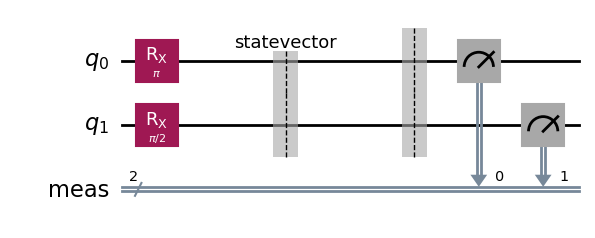

In [6]:
q = QuantumCircuit(2)
q.rx(np.pi, 0)
q.rx(np.pi/2,1)
q.save_statevector()
q.measure_all()
q.draw('mpl')

In [7]:
result = simulator_aer.run(q).result()
statevec = result.get_statevector()

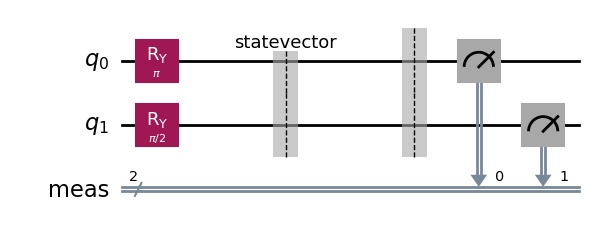

In [8]:
qy = QuantumCircuit(2)
qy.ry(np.pi, 0)
qy.ry(np.pi/2, 1)
qy.save_statevector()
qy.measure_all()
qy.draw('mpl')


In [9]:
resulty = simulator_aer.run(qy).result()
statevecy = result.get_statevector()

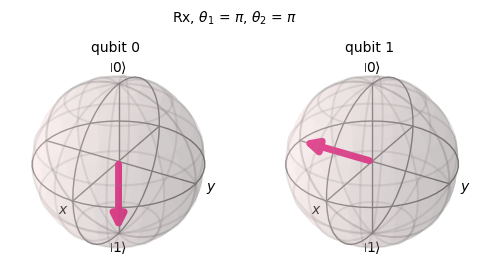

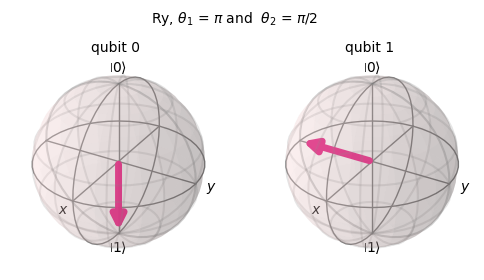

In [10]:


display(plot_bloch_multivector(statevec,figsize = (3,3),title_font_size = 10, title=r'Rx, $\theta_1$ = $\pi$, $\theta_2$ = $\pi$ '))
display(plot_bloch_multivector(statevecy,figsize = (3,3),title_font_size = 10, title=r'Ry, $\theta_1$ = $\pi$ and  $\theta_2$ = $\pi/2$'))


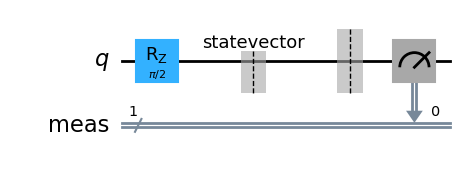

{'0': 1024}


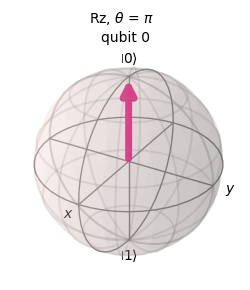

In [11]:
qz = QuantumCircuit(1)
qz.rz(np.pi/2, 0)
qz.save_statevector()
qz.measure_all()
display(qz.draw('mpl'))
resultz = simulator_aer.run(qz).result()
statevecz = resultz.get_statevector()
countsz = resultz.get_counts()

print(countsz)
display(plot_bloch_multivector(statevecz, figsize = (3,3), font_size = 10,title=r'Rz, $\theta$ = $\pi$ '))

Outra forma de atingir os mesmos resultados é através da matriz U3, porta do qiskit:
$$
U3(\theta, \phi, \lambda) = \begin{bmatrix}
cos\frac{\theta}{2} & -e^{i\lambda}sin\frac{\theta}{2} \\
e^{i\phi}sin\frac{\theta}{2} & e^{i(\phi + \lambda)}cos\frac{\theta}{2}
\end{bmatrix}
$$

Pode-se perceber que:
$$
\begin{align}
& U3(\theta, -\frac{\pi}{2}, \frac{\pi}{2}) = R_X(\theta) \\
& U3(\theta, 0, 0) = R_Y(\theta)
\end{align}
$$

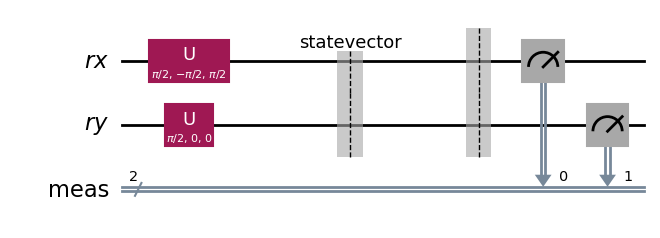

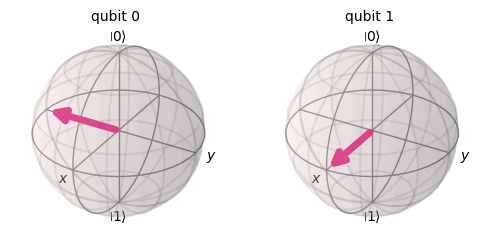

In [12]:
q1 = QuantumRegister(1, 'rx')
q2 = QuantumRegister(1, 'ry')
qu = QuantumCircuit(q1,q2)
qu.u(np.pi/2, -np.pi/2, np.pi/2, qubit = 0)
qu.u(np.pi/2, 0,0, qubit = 1)
qu.save_statevector()
qu.measure_all()
display(qu.draw('mpl'))
r = simulator_aer.run(qu).result()
state = r.get_statevector()
display(plot_bloch_multivector(state, figsize = (3,3)))

Agora, na construção de pulsos compostos é necessário mudar a fase do plano de sua rotação. Considerando uma rotação no ângulo $\theta$ em torno de um eixo no plano XY, definido pelo ângulo $\phi$:

$$
R_\phi (\theta) = e^{-i\frac{\theta}{2}(cos\phi X + sin \phi Y)}
$$

Dessa forma, se $\phi = 0$, $R_0 (\theta) = R_X (\theta)$, ou se $\phi = \frac{\pi}{2}$, $R_{\frac{\pi}{2}}(\theta) = R_Y (\theta)$. Dessa forma, podemos definir essas rotações usando a porta U3 ou as portas Rx, Ry e Rz definidas anteriormente. 

Uma rotação, por exemplo, que será usada é $(\pi)_{\pi/6}$. Podemos definir a rotação acima, através da fórmula:

$$
R_{\phi}(\theta) = R_Z(-\phi)R_X(\theta)R_Z(\phi)
$$

Logo, podemos usar as rotações Rx e Rz disponibilizadas no qiskit para verificar e visualizar os pulsos compostos. 

Agora, vamos buscar mostrar que apesar de erros no ângulo de rotação podemos usar a sequência BB1 capaz de corrigir:
Dado a rotação:
$$
\begin{equation}
R_\phi (\theta) = e^{-i\frac{\theta}{2}(cos\phi X + sin \phi Y)}
\end{equation}
$$
Temos um erro de $\epsilon$
$$
R_\phi (\theta(1 + \epsilon)) = e^{-i\frac{\theta(1 + \epsilon)}{2}(cos\phi X + sin \phi Y)}
$$

O pulso é definido como:
$$
R_\phi (\theta) ^{\text{ideal}} = R_\phi (\frac{\theta}{2}) R_{\phi + \beta} (\pi) R_{\phi + 3\beta} (2\pi) R_{\phi + \beta} (\pi) R_\phi (\frac{\theta}{2})
$$

$\beta = cos^{-1}(-\frac{\theta}{4\pi})$ 

Aqui, usamos um erro no ângulo de rotação: $\theta(1 + \epsilon)$ em cada uma das rotações aplicadas. A métrica que vamos usar para avaliar se a rotação se aproxima da que queremos é a fidelidade - vamos usar a função state_fidelity https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.quantum_info.state_fidelity - e também iremos plotar a probabilidade do estado estar em 1, ou seja, rotacionou em $\pi$. Em teoria, enquanto o pulso de $R_X$ apresentaria uma curva com um pico quando $\epsilon = 0$ e diferente disso ela diminui, chegando em zero nos casos mais extremos, a curva do pulso composto se manteria no pico, embora $\epsilon$ estivesse diferente de $0$, podendo decrescer nos casos mais extremos.

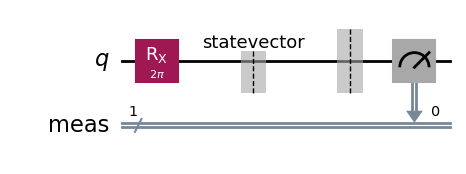

In [139]:

erro = np.arange(-1, 1.1, 0.1)
eps = Parameter('eps')

qc = QuantumCircuit(1)
qc.rx( (np.pi)*(1+ eps), 0)
qc.save_statevector()
qc.measure_all()

circuits = [qc.assign_parameters({eps: a}, inplace = False) for a in erro]
display(circuits[-1].draw('mpl'))

Para aplicar uma rotação no plano $XY$ definida pelo ângulo $\phi$ em $\theta$ graus $R_{\phi}(\theta)$, como definida anteriormente, usaremos a seguinte igualdade:
$$
R_\phi (\theta) = R_z(-\phi)R_x(\theta)R_z(\phi)
$$

In [140]:
def composite_pulse(theta, phi, eps):
    qc = QuantumCircuit(1)
    beta = np.arccos(-(np.pi/(4*np.pi)))
    
    qc.rz(-phi,0)
    qc.rx(((theta*(1+ eps))/2), 0 )
    qc.rz(phi, 0)
    
    qc.barrier()
    
    qc.rz(-(phi+beta),0)
    qc.rx(np.pi*(1+eps), 0)
    qc.rz(phi+beta,0)
    
    qc.barrier()
    
   
    qc.rz(-(phi+3*beta),0)
    qc.rx(2*np.pi*(1+eps), 0)
    qc.rz(phi+3*beta,0)
    
    qc.barrier()

    qc.rz(-(phi+beta),0)
    qc.rx(np.pi*(1+eps), 0)
    qc.rz(phi+beta,0)
    
    qc.barrier()
    
    qc.rz(-phi,0)
    qc.rx(((theta*(1+ eps))/2), 0 )
    qc.rz(phi, 0)
    
    qc.save_statevector()
    
    qc.measure_all()
    
    return qc
    

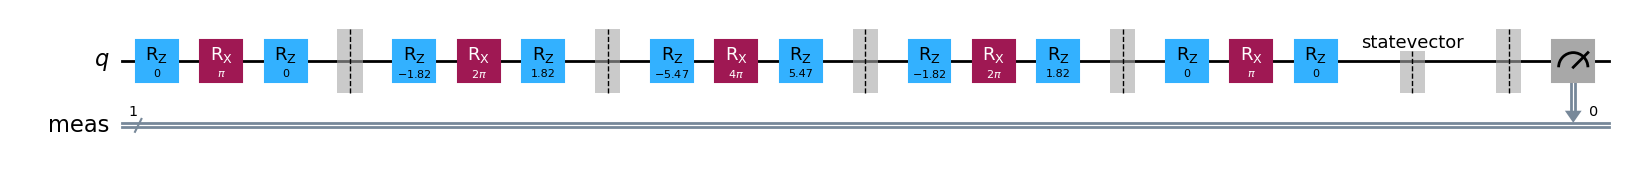

In [141]:
qcp = composite_pulse( (np.pi), 0 ,eps)

circuits_cp = [qcp.assign_parameters({eps: a}, inplace = False) for a in erro]
display(circuits_cp[-1].draw('mpl'))

In [142]:
results = []
for i in circuits:
    results.append(simulator_aer.run(i).result())
results_cp = []
for i in circuits_cp:   
    results_cp.append(simulator_aer.run(i).result())

state_vectors = [i.get_statevector() for i in results]
state_vectors_cp = [j.get_statevector() for j in results_cp]


fidelity_cp = [state_fidelity(state_vector_id, state_vectors_cp[i]) for i in range(len(results))]
fidelity_ = [state_fidelity(state_vector_id, state_vectors[i]) for i in range(len(results))]
counts = [i.get_counts() for i in results]
counts_cp = [i.get_counts() for i in results_cp]

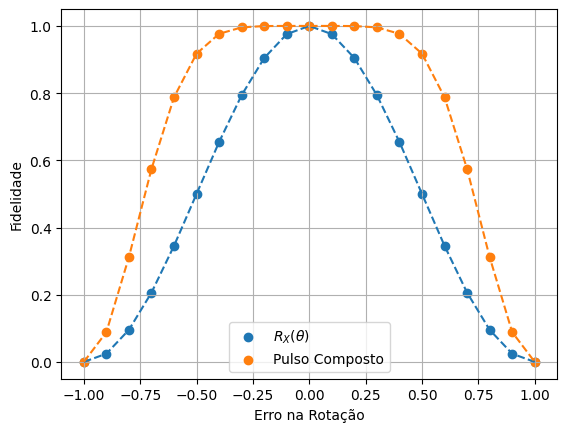

In [143]:
plt.scatter(erro, fidelity_, label = r'$R_X(\theta)$')
plt.plot(erro,fidelity_, '--')
plt.scatter(erro, fidelity_cp, label = 'Pulso Composto')
plt.plot(erro,fidelity_cp, '--')

plt.xlabel('Erro na Rotação')
plt.ylabel('Fidelidade')

plt.grid()

plt.legend()
plt.show()

In [144]:
for entry in counts:
    if '0' in entry and entry['0'] == 1024:
        entry['1'] = 0
    elif '1' in entry and entry['1'] == 1024:
        entry['0'] = 0
for entry in counts_cp:
    if '0' in entry and entry['0'] == 1024:
        entry['1'] = 0
    elif '1' in entry and entry['1'] == 1024:
        entry['0'] = 0

In [145]:
prob_1_cp = [i['1']/sum(i.values()) for i in counts_cp]
prob_1 = [i['1']/sum(i.values()) for i in counts]

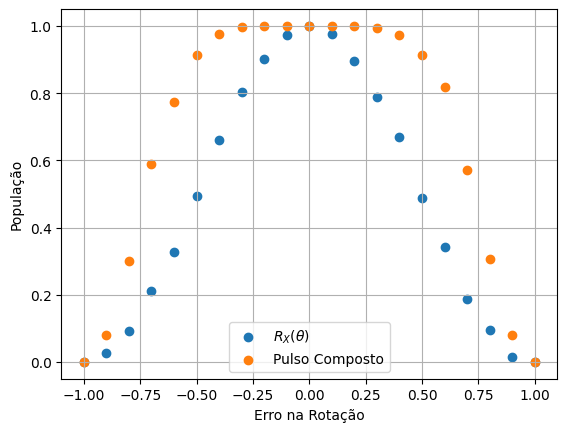

In [146]:
plt.scatter(erro, prob_1, label = r'$R_X(\theta)$')
plt.scatter(erro, prob_1_cp, label = 'Pulso Composto')

plt.xlabel('Erro na Rotação')
plt.ylabel('População')

plt.grid()

plt.legend()
plt.show()

$$
R_\phi (\theta) = e^{-i\frac{\theta}{2}(cos\phi X + sin \phi Y) + 2\pi \lambda Z/2}
$$
Sendo $\lambda$ o erro na frequência.

In [147]:
def composite_pulse(theta, phi, eps):
    qc = QuantumCircuit(1)
    beta = np.arccos(-(np.pi/(4*np.pi)))
    
    qc.rz(-phi,0)
    qc.rx(((theta)/2), 0 )
    qc.rz(phi, 0)
    qc.rz(2*np.pi*eps,0)
    
    qc.barrier()
    
    qc.rz(-(phi+beta),0)
    qc.rx(np.pi, 0)
    qc.rz(phi+beta,0)
    qc.rz(2*np.pi*eps,0)
    
    qc.barrier()
    
   
    qc.rz(-(phi+3*beta),0)
    qc.rx(2*np.pi, 0)
    qc.rz(phi+3*beta,0)
    qc.rz(2*np.pi*eps,0)
    
    qc.barrier()

    qc.rz(-(phi+beta),0)
    qc.rx(np.pi, 0)
    qc.rz(phi+beta,0)
    qc.rz(2*np.pi*eps,0)
    
    qc.barrier()
    
    qc.rz(-phi,0)
    qc.rx(((theta)/2), 0 )
    qc.rz(phi, 0)
    qc.rz(2*np.pi*eps,0)
    
    qc.save_statevector()
    
    qc.measure_all()
    
    return qc
    

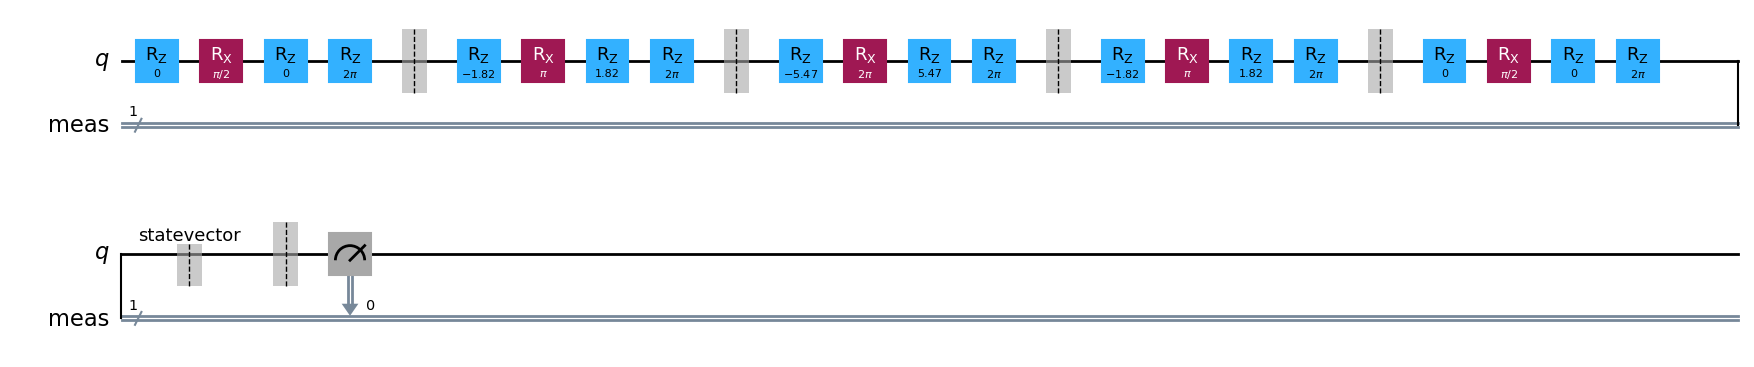

In [148]:
erro = np.arange(-1., 1.1,0.1)
eps = Parameter('eps')
qcp_freq = composite_pulse( (np.pi), 0 ,eps)

circuits_cp_f = [qcp_freq.assign_parameters({eps: a}, inplace = False) for a in erro]
display(circuits_cp_f[-1].draw('mpl'))

results = []
for i in circuits_cp_f:
    results.append(simulator_aer.run(i).result())


state_vectors_cp = [j.get_statevector() for j in results]


fidelity_cp = [state_fidelity(state_vector_id, state_vectors_cp[i]) for i in range(len(results))]

counts = [i.get_counts() for i in results]


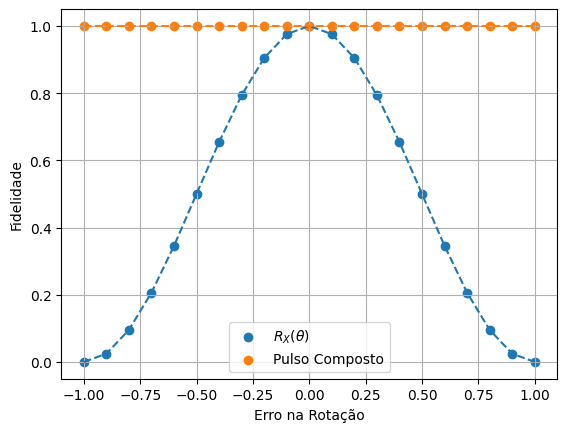

In [149]:
plt.scatter(erro, fidelity_, label = r'$R_X(\theta)$')
plt.plot(erro,fidelity_, '--')
plt.scatter(erro, fidelity_cp, label = 'Pulso Composto')
plt.plot(erro,fidelity_cp, '--')

plt.xlabel('Erro na Rotação')
plt.ylabel('Fidelidade')

plt.grid()

plt.legend()
plt.show()